In [8]:
import os
import gc
import pandas as pd
import numpy as np
import lightgbm as lgbm
# import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import roc_auc_score, roc_curve
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error


""" Load and process inputs """
input_dir = './input/'
print('Input files:\n{}'.format(os.listdir(input_dir)))
print('Loading data sets...')

# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def one_hot_encoder(df, nan_as_category = True, keep_columns = None, max_num_of_unique_items = 31):
    original_columns = list(df.columns)
    if keep_columns is None:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    else:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col not in keep_columns]
    for col in categorical_columns:
        if len(df[col].unique()) > max_num_of_unique_items :
            categorical_columns = list(set(categorical_columns) - set([col]))
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2)))

Input files:
['flat.csv', 'price.csv', 'status.csv', 'test.csv', 'test_.csv', 'train.cd', 'train.csv', 'train2.cd', 'train_0.csv', 'train_1.csv', 'train_2.csv', 'train_3.csv', 'train_4.csv', 'train_5.csv', 'train_6.csv', 'train_7.csv', 'train_8.csv', 'train_9.csv', 'train_full.csv', 'valid_0.csv', 'valid_1.csv', 'valid_2.csv', 'valid_3.csv', 'valid_4.csv', 'valid_5.csv', 'valid_6.csv', 'valid_7.csv', 'valid_8.csv', 'valid_9.csv']
Loading data sets...


In [2]:
def get_prices():
    prices = reduce_mem_usage(pd.read_csv('./input/price.csv',
                                         encoding='cp1251',
                                         parse_dates=['datefrom','dateto']))
    prices.drop(['date_salestart'], axis = 1, inplace = True)
    # prices["datefrom_week"] = prices['datefrom'].dt.week
    prices["datefrom_month"] = prices['datefrom'].dt.month
    # prices["dateto_week"] = prices['dateto'].dt.week
    prices["dateto_month"] = prices['dateto'].dt.month
    prices["have_price"] = prices['pricem2'].apply(lambda x: 1 if x > 50000 else 0)
    prices["not_saled"] = prices['dateto'].apply(lambda x: 1 if x == '2100-01-01 00:00:00' else 0)
    prices['sales_duration'] = ((prices['dateto'] - prices['datefrom'])/30).dt.days
    prices["sales_duration"] = prices['sales_duration'].apply(lambda x: x if x > 900 else 0)

    # unique_df = prices.nunique()
    # dummy_features = list(unique_df[unique_df <= 12].index)
    # prices = pd.get_dummies(prices, columns=dummy_features, dummy_na=True)
    # del unique_df
    aggregations = {}
    aggregations = {
                'pricem2': ['min','max','mean','count'],
#                 'datefrom_month': ['mean'],
#                 'dateto_month': ['mean'],
#                 'have_price': ['mean'],
#                 'not_saled': ['mean'],
#                 'sales_duration': ['min', 'mean'],
            }

    # for cat in dummy_features:
    #         aggregations[cat] = ['mean', 'min', 'max']

    prices_agg = prices.groupby('id_flatwork').agg(aggregations)
    prices_agg.columns = pd.Index(['PRICES_' + e[0] + "_" + e[1].upper() for e in prices_agg.columns.tolist()])
    return prices_agg

def add_lags(df, feat, index='new_index_spalen', by_col='month_cnt', aggfunc=np.mean):
    temp = pd.pivot_table(df, index=index, values=[feat], columns=by_col, aggfunc=aggfunc)
#     temp = df.pivot(index=index, values=[feat], columns=by_col)
    cols = [feat+'_'+by_col+'_{}'.format(j[1]) if j[1] != "" else j[0] for i, j in enumerate(temp.columns)]
    temp.columns = cols
    temp[feat+'_lag_1'] = 0
    for row_idx in range(temp.shape[0]):
        for idx in range(len(cols)):
            value = temp.iloc[row_idx, -idx-2]
            if not np.isnan(value) :
                temp.iloc[row_idx, -1] = value
                break
    new_cols = [feat+'_lag_1']
    return temp, new_cols

kfold_treshholds = [(30,32), (32,34), (33,35), (34,35)]
def get_fold_by_col(df, col, start, end):
    df_copy = df.reset_index()
    train_idx = df_copy[df_copy[col] <= start].index
    valid_idx = df_copy[df_copy[col].between(start,end)].index
    del df_copy
    return train_idx, valid_idx

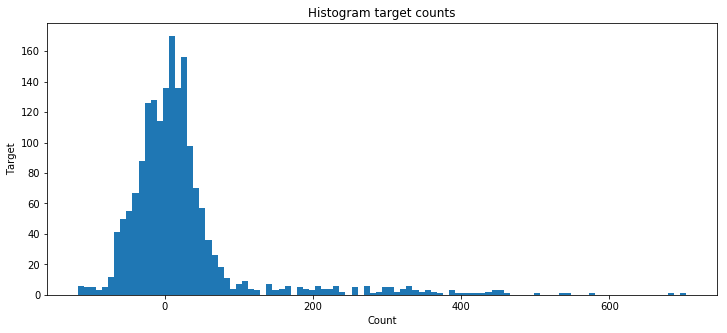

In [28]:
plt.figure(figsize=(12,5))
plt.hist(df.value.values, bins = 100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

In [38]:
idx = 0
for col in df_train.columns.tolist():
    print(idx, len(df_train[col].unique()), col)
    idx += 1

0 8726 id
1 233 bulk_id
2 5 spalen
3 7025 price
4 3792 mean_sq
5 32 mean_fl
6 12 month
7 31 month_cnt
8 3 Класс объекта
9 29 Количество помещений
10 2 Огорожена территория
11 29 Площадь земельного участка
12 2 Входные группы
13 21 Детский сад
14 16 Школа
15 4 Поликлиника
16 2 ФОК
17 1 Спортивная площадка
18 2 Автомойка
19 2 Кладовые
20 2 Колясочные
21 3 Кондиционирование
22 3 Вентлияция
23 1 Лифт
24 1 Система мусоротведения
25 3 Видеонаблюдение
26 2 Подземная парковка
27 2 Двор без машин
28 29 Машиномест
29 128 Площадь пром. зоны в радиусе 500 м
30 173 Площадь зеленой зоны в радиусе 500 м
31 17 До Кремля
32 22 До ТТК(км)
33 17 До Садового(км)
34 105 До большой дороги на машине(км)
35 79 До удобной авторазвязки на машине(км)
36 81 До метро пешком(км)
37 79 До промки(км)
38 95 До парка(км)
39 92 До парка пешком(км)
40 10 Станций метро от кольца
41 123 Площадь двора
42 31 Курс
43 30 Cтавка по ипотеке
44 30 Вклады до 1 года
45 31 Вклады от 1 года до 3 лет
46 30 Вклады свыше 3 лет
47 3072 m

In [ ]:
for s in range(num_seeds):
    for fold in range(n_folds):
        iter_num += 1
        df_train = pd.read_csv('./input/train_{}.csv'.format(fold))
        df_valid = pd.read_csv('./input/valid_{}.csv'.format(fold))
        target_train = df_train.pop('value')
        target_valid = df_valid.pop('value')
        df_meta = pd.read_csv("./output/oof_lgbm_{}.csv".format(fold), columns=['id','value'])

In [204]:
import pandas as pd
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import numpy as np
iter_num = 0
n_folds = 7
avg_score = 0
feature_importance_df = pd.DataFrame()
df_train = pd.read_csv('./input/train_full.csv', encoding='cp1251')
# df_train.to_csv('./input/train_full_lgbm.csv', encoding='cp1251')
# df_oof = np.zeros((len(df), n_folds))
# df_meta = pd.read_csv('submission_catboost_211.43605189630915_199_05136.csv')
df_test = pd.read_csv('./input/test_.csv')

# df_test['metafeature_catboost'] = df_meta['value']
test = np.zeros((len(df_test), 1))
oof = np.zeros((len(df_train), 1))
num_seeds = 1
for s in range(num_seeds):
    for fold in range(n_folds):
        iter_num += 1
        df_train = pd.read_csv('./input/train_month_folds_{}.csv'.format(fold))
        df_valid = pd.read_csv('./input/valid_month_folds_{}.csv'.format(fold))
        target_train = df_train.pop('value')
        target_valid = df_valid.pop('value')

        discard_feats = ['id','bulk_id','date1','bulk_id_5']

        cat_feats = ['spalen', 'month', 'Класс объекта',
         'Огорожена территория', 'Входные группы', 'Детский сад', 'Школа',
         'Поликлиника', 'ФОК', 'Спортивная площадка', 'Автомойка',
         'Кладовые', 'Колясочные', 'Кондиционирование', 'Вентлияция',
         'Лифт', 'Система мусоротведения', 'Видеонаблюдение', 'Подземная парковка',
         'Двор без машин', 'flag_sales_started']

        feats = [f for f in df_train.columns.tolist() if f not in discard_feats]
    #     feats = [f for f in feats if f not in cat_feats]

        lgtrain = lgb.Dataset(df_train[feats], target_train,
                            feature_name=feats,
                            categorical_feature = cat_feats
                             )
        lgvalid = lgb.Dataset(df_valid[feats], target_valid,
                            feature_name=feats,
                            categorical_feature = cat_feats
                             )

        lgbm_params =  {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            # 'max_depth': 15,
            'num_leaves': 34,
            'nthread':4,
            'learning_rate': 0.005,
            'colsample_bytree': 0.8,
            'subsample': 0.87,
            'max_depth': -1,
            'reg_alpha': 0.04,
            'min_split_gain': 0.017,
            'min_child_weight': 20,
            'verbose': -1,
            'silent':-1,
            'seed':s,
            'random_state':s
        }

        lgb_clf = lgb.train(
                lgbm_params,
                lgtrain,
                num_boost_round=10000,
                valid_sets=[lgtrain, lgvalid],
                valid_names=['train','valid'],
                early_stopping_rounds=300,
                verbose_eval=10000
            )
        # print('RMSE:', np.sqrt(mean_squared_error(target_valid, lgb_clf.predict(df_valid[feats]))))
        pred = lgb_clf.predict(df_test[feats])
        test += pred.reshape((len(df_test),1))
        df_test['value'] = pred
        df_test.to_csv("./output/test_lgbm_m_{}.csv.".format(fold), index=False, columns=['id','value'])
        pred = lgb_clf.predict(df_valid[feats])
        df = pd.read_csv("./input/valid_month_folds_{}.csv.".format(fold))
        oof[df.id] = pred.reshape((len(df),1))
        df['value'] = pred
        df.to_csv("./output/oof_lgbm_m_{}.csv".format(fold), index=False, columns=['id','value'])
    #     full_train = pd.read_csv('./input/train_full_lgbm.csv', encoding='cp1251')
    #     full_train['oof_'.format(fold)] = pred
    #     full_train.to_csv('./input/train_full_lgbm.csv', encoding='cp1251')
    #     oof_score = model.score(val_pool, oof_value)
    #     print('Iteration {} with oof score {}'.format(i, oof_score))
        oof_score = mean_squared_error(target_valid, pred)**0.5
        avg_score += oof_score
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = lgb_clf.feature_importance
        fold_importance_df["fold"] = fold + 1
        fold_importance_df["seed"] = s
        fold_importance_df['oof_score'] = oof_score
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

df = pd.read_csv('./input/sample submission.csv', encoding='cp1251')

df['value'] = (test/iter_num).clip(0, 3000)
df.to_csv('submission_lgbm_m_'+str(avg_score/(iter_num))+'.csv', index=False)
print('Score {}'.format(avg_score/iter_num))
# df = pd.read_csv(path+"train_full.csv", encoding='cp1251')
# df['value_pred'] = oof
# df.to_csv('./output/oof_'+str(avg_score/(i+1))+'.csv', index=False)

C:\Users\Wisp\Anaconda4\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Wisp\Anaconda4\lib\site-packages\lightgbm\basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\Wisp\Anaconda4\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[263]	train's rmse: 262.263	valid's rmse: 216.666
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1477]	train's rmse: 146.227	valid's rmse: 204.498
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[7158]	train's rmse: 65.129	valid's rmse: 246.94
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2335]	train's rmse: 124.272	valid's rmse: 265.343
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1880]	train's rmse: 137.804	valid's rmse: 221.118
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[821]	train's rmse: 182.992	valid's rmse: 233.093
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[714]	train'

In [174]:
len(lgb_clf.predict(df_test[feats]))

1770

In [192]:
from sklearn.model_selection import KFold
import pandas as pd
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import numpy as np

df_stack_meta1 = pd.DataFrame()
df_stack_meta2 = pd.DataFrame()

for i in range(10):
    df = pd.read_csv('./output/oof_{}.csv'.format(i))
    val = df['value']
    df_stack_meta1 = pd.concat([df_stack_meta1, df])

    df = pd.read_csv('./output/oof_lgbm_{}.csv'.format(i))
    val = df['value']
    df_stack_meta2 = pd.concat([df_stack_meta2, df])
df_stack_meta1 = df_stack_meta1.sort_values(['id']).set_index(['id'])
df_stack_meta2 = df_stack_meta2.sort_values(['id']).set_index(['id'])

K = 10
df = pd.read_csv("./input/train_full.csv")
df['metafeature_catboost'] = df_stack_meta1['value']
df['metafeature_lgbm'] = df_stack_meta2['value']

df_test = pd.read_csv('./input/test_.csv')
df_stack_meta1 = pd.read_csv('submission_catboost_212.64175801420384_198.csv')
df_stack_meta2 = pd.read_csv('submission_lgbm_207.2784140815164_205_224.csv')
df_test['metafeature_catboost'] = df_stack_meta1['value']
df_test['metafeature_lgbm'] = df_stack_meta2['value']

kf = KFold(n_splits=K, random_state=100, shuffle=True)
kf.get_n_splits(range(len(df)))

print(kf)  

for i, (train_index, valid_index) in enumerate(kf.split(range(len(df)))):
    train = df.loc[train_index]
    valid = df.loc[valid_index]

    train.to_csv(f"./input/train_meta_cb_{i}.csv",index=False)
    valid.to_csv(f"./input/valid_meta_cb_{i}.csv",index=False)

df_test.to_csv('./input/test_meta.csv',index=False)
    
iter_num = 0
n_folds = 10
avg_score = 0
feature_importance_df = pd.DataFrame()
df_train = pd.read_csv('./input/train_full.csv', encoding='cp1251')
# df_train.to_csv('./input/train_full_lgbm.csv', encoding='cp1251')
# df_oof = np.zeros((len(df), n_folds))
# df_meta = pd.read_csv('submission_catboost_211.43605189630915_199_05136.csv')
# df_test = pd.read_csv('./input/test_.csv')

# df_test['metafeature_catboost'] = df_meta['value']
test = np.zeros((len(df_test), 1))
oof = np.zeros((len(df_train), 1))
num_seeds = 1
for s in range(num_seeds):
    for fold in range(n_folds):
        iter_num += 1
        df_train = pd.read_csv('./input/train_meta_cb_{}.csv'.format(fold))
        df_valid = pd.read_csv('./input/valid_meta_cb_{}.csv'.format(fold))
        target_train = df_train.pop('value')
        target_valid = df_valid.pop('value')

        discard_feats = ['id','bulk_id','date1','bulk_id_5']

        cat_feats = ['spalen', 'month', 'Класс объекта',
         'Огорожена территория', 'Входные группы', 'Детский сад', 'Школа',
         'Поликлиника', 'ФОК', 'Спортивная площадка', 'Автомойка',
         'Кладовые', 'Колясочные', 'Кондиционирование', 'Вентлияция',
         'Лифт', 'Система мусоротведения', 'Видеонаблюдение', 'Подземная парковка',
         'Двор без машин', 'flag_sales_started']

        feats = [f for f in df_train.columns.tolist() if f not in discard_feats]
#         feats = ['metafeature_catboost','metafeature_lgbm']

        lgtrain = lgb.Dataset(df_train[feats], target_train,
                            feature_name=feats,
                            categorical_feature = cat_feats
                             )
        lgvalid = lgb.Dataset(df_valid[feats], target_valid,
                            feature_name=feats,
                            categorical_feature = cat_feats
                             )

        lgbm_params =  {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            # 'max_depth': 15,
            'num_leaves': 34,
            'nthread':4,
            'learning_rate': 0.01,
            'colsample_bytree': 0.8,
            'subsample': 0.87,
            'max_depth': -1,
            'reg_alpha': 0.04,
            'min_split_gain': 0.017,
            'min_child_weight': 20,
            'verbose': -1,
            'silent':-1,
            'seed':s,
            'random_state':s
        }

        lgb_clf = lgb.train(
                lgbm_params,
                lgtrain,
                num_boost_round=10000,
                valid_sets=[lgtrain, lgvalid],
                valid_names=['train','valid'],
                early_stopping_rounds=300,
                verbose_eval=10000
            )
        # print('RMSE:', np.sqrt(mean_squared_error(target_valid, lgb_clf.predict(df_valid[feats]))))
        pred = lgb_clf.predict(df_test[feats])
        test += pred.reshape((len(df_test),1))
        df_test['value'] = pred
#         df_test.to_csv("./output/test_lgbm_{}.csv.".format(fold), index=False, columns=['id','value'])
        pred = lgb_clf.predict(df_valid[feats])
        df = pd.read_csv("./output/oof_{}.csv.".format(fold))
        oof[df.id] = pred.reshape((len(df),1))
        df['value'] = pred
#         df.to_csv("./output/oof_lgbm_{}.csv".format(fold), index=False, columns=['id','value'])
    #     full_train = pd.read_csv('./input/train_full_lgbm.csv', encoding='cp1251')
    #     full_train['oof_'.format(fold)] = pred
    #     full_train.to_csv('./input/train_full_lgbm.csv', encoding='cp1251')
    #     oof_score = model.score(val_pool, oof_value)
    #     print('Iteration {} with oof score {}'.format(i, oof_score))
        oof_score = mean_squared_error(target_valid, pred)**0.5
        avg_score += oof_score
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = lgb_clf.feature_importance
        fold_importance_df["fold"] = fold + 1
        fold_importance_df["seed"] = s
        fold_importance_df['oof_score'] = oof_score
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

df = pd.read_csv('./input/sample submission.csv', encoding='cp1251')

df['value'] = (test/iter_num).clip(0, 3000)
df.to_csv('submission_lgbm_meta_'+str(avg_score/(iter_num))+'.csv', index=False)
print('Score {}'.format(avg_score/iter_num))
# df = pd.read_csv(path+"train_full.csv", encoding='cp1251')
# df['value_pred'] = oof
# df.to_csv('./output/oof_'+str(avg_score/(i+1))+'.csv', index=False)

KFold(n_splits=10, random_state=100, shuffle=True)


C:\Users\Wisp\Anaconda4\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Wisp\Anaconda4\lib\site-packages\lightgbm\basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\Wisp\Anaconda4\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[220]	train's rmse: 190.315	valid's rmse: 212.598
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[248]	train's rmse: 186.064	valid's rmse: 211.116
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[325]	train's rmse: 178.072	valid's rmse: 200.056
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[724]	train's rmse: 150.835	valid's rmse: 216.286
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[158]	train's rmse: 201.183	valid's rmse: 223.671
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4259]	train's rmse: 66.5025	valid's rmse: 204.342
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[731]	train's

In [195]:
df_stack_meta1 = pd.read_csv('submission_catboost_212.64175801420384_198.csv')
df_stack_meta2 = pd.read_csv('submission_lgbm_207.2784140815164_205_224.csv')
sub = df_stack_meta1
sub['value'] = (df_stack_meta1['value'] + df_stack_meta2['value'])/2
sub.to_csv('sub_ans.csv')

In [157]:
df = pd.read_csv('./output/test_0.csv')
pred = np.zeros((len(df), ))

for i in [0,2,3,4,5]:
    if i != 6:
        df = pd.read_csv('./output/test_{}.csv'.format(i))
        val = df['value']
        pred += val
    
df = pd.read_csv("./input/sample submission.csv", encoding='cp1251')
df['value'] = (pred/9).clip(0, 5000)
df.to_csv('submission_catboost_5_folds.csv', index=False)

Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)


C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Starting LightGBM. Train shape: (8726, 80), test shape: (1770, 81)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5682]	training's rmse: 73.5159	valid_1's rmse: 222.74
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5822]	training's rmse: 73.7339	valid_1's rmse: 184.692
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[9143]	training's rmse: 51.6095	valid_1's rmse: 218.562
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[8424]	training's rmse: 56.3467	valid_1's rmse: 216.179
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3734]	training's rmse: 94.4016	valid_1's rmse: 234.64
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4764]	training's rmse: 83.1131	valid_1's rmse: 234.966
Training u

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


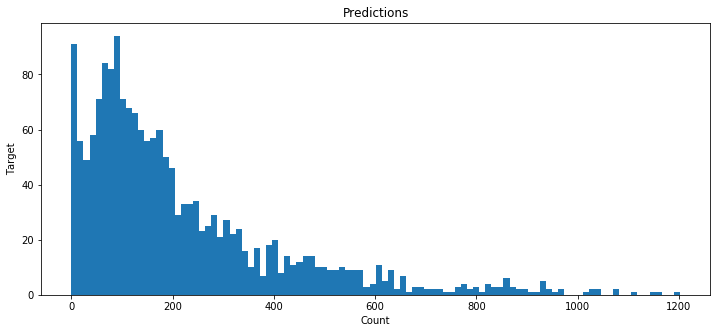

In [157]:
df = get_df_for_submit()
target_column = 'value'

train_df = df[df[target_column].notnull()]
test_df = df[df[target_column].isnull()]

num_folds = 10
nseeds = 1
target = train_df.pop(target_column)
# target = np.log1p(target)

feats = train_df.columns.tolist()
print("\nStarting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
gc.collect()
    # Cross validation model
folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
avg_score = 0
run_times = 0

discard_columns = ['bulk_id', 'bulk_id_1', 'bulk_id_2', 'bulk_id_3', 'bulk_id_4','new_index_unique',
                       'new_index_unique_lag_1','new_index_unique_lag_2','new_index_unique_lag_3',
                       'new_index_unique_lag_4','new_index_unique_lag_5','new_index_unique_lag_6',
                       'new_index_spalen','Курс', 'end_square', 'bulk_id_5', target_column, 'date1']

feats = list(set(list(feats)) - set(discard_columns))
# feats = list(set(list(feats)) - set(not_important_features))

    # feats = list(train_df.columns)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], target)):
    train_x, train_y = train_df[feats].iloc[train_idx], target.iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], target.iloc[valid_idx]
    nseeds = nseeds
    for s in range(nseeds):
        test_df_clear = test_df.copy()
        run_times += 1
            # LightGBM parameters found by Bayesian optimization
        clf = LGBMRegressor(
    #                     boosting = 'dart',
#                         device_type='gpu',
                        nthread=4,
                        n_estimators=10000,
                        learning_rate=0.01,
                        num_leaves=34,
                        colsample_bytree=0.8,
                        subsample=0.87,
                        max_depth=-1,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.017,
                        min_child_weight=20,
                        silent=-1,
                        verbose=-1, 
                        seed=s,
                        random_state=s)
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                            eval_metric= 'rmse', verbose= 15000, early_stopping_rounds= 300)

        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
#         oof_preds[valid_idx] = np.expm1(oof_preds[valid_idx])
        y_pred = clf.predict(test_df_clear[feats], num_iteration=clf.best_iteration_)
#         y_pred = np.expm1(y_pred)
    #         test_df_clear[target_column] = y_pred

    #         temp, new_cols = add_lags(test_df_clear, feat='value', index='new_index_spalen', by_col='month_cnt')
    #         test_df_clear.drop(new_cols, inplace=True, axis=1)
    #         test_df_clear = test_df_clear.merge(temp[new_cols], on='new_index_spalen',  how='left')
    #         y_pred = clf.predict(test_df_clear[feats], num_iteration=clf.best_iteration_)

        sub_preds +=  pd.Series(y_pred).values #/ folds.n_splits
        test_df_clear['value'] = sub_preds
        test_df_clear.to_csv('test_'+str(run_times)+'.csv')
        oof_score = mean_squared_error(valid_y, oof_preds[valid_idx])**0.5
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        fold_importance_df["seed"] = s
        fold_importance_df['oof_score'] = oof_score
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            # print('Fold %2d Seed %i AUC : %.6f' % (n_fold + 1, s, score))
        avg_score +=  oof_score
    #del clf, train_x, train_y, valid_x, valid_y
gc.collect()

print(avg_score/run_times)
test_df['value'] = np.clip(sub_preds/run_times, 0, None)
test_df['id'] = list(range(len(test_df)))
test_df[['id','value']].to_csv('submission_v2_'+str(avg_score/run_times)+'_.csv', index=False)

plt.figure(figsize=(12,5))
plt.hist(test_df['value'], bins = 100)
plt.title('Predictions')
plt.xlabel('Count')
plt.ylabel('Target')

plt.show()

In [151]:
def get_df(param):
    df = pd.read_csv(os.path.join(input_dir,'train.csv'), parse_dates=['date1'], encoding='cp1251')
    df_test = pd.read_csv(os.path.join(input_dir,'test.csv'), parse_dates=['date1'], encoding='cp1251')
    absent_columns = list(set(df.columns) - set(list(df_test.columns))-set(['value']))
    df.drop(absent_columns, axis=1, inplace=True)
    
#     df = df[df.value > 0]
#     df.value = np.log1p(df.value)
#     df['value'] = np.clip(df['value'],0,1500)
#     df['value'] = np.round(df['value']* df['price'],decimals=0)
#     df=df[df.spalen == param]
    
    test_df = df[df.month_cnt >= 35]
    test_target = test_df['value']
    test_df['value'] = 0
    train_df = df[df.month_cnt <= 34]
#     train_df = train_df[train_df.month_cnt >= param]
#     train_df = train_df[train_df.value > 0]
    train_df['value'] = np.clip(train_df['value'],0,5000)
    
    df = pd.concat([train_df,test_df])
    
    df['mean_sq_spalen'] = df['mean_sq'] / (df['spalen']+1)
    df['mean_sq*price'] = df['mean_sq']*df['price'] ## 220.94
    df['spalen*Площадь зеленой зоны в радиусе 500 м'] = df['spalen']*df['Площадь зеленой зоны в радиусе 500 м'] ## 220,04
    df['spalen*month_cnt'] = df['spalen']*df['month_cnt'] ## 219.77
    df['mean_sq*До удобной авторазвязки на машине(км)'] = df['mean_sq']*df['До удобной авторазвязки на машине(км)'] ## 219.78
    df['Станций метро от кольца*price'] = df['Станций метро от кольца']*df['price'] ## 219.19
    
    
    df['price-*-mean_sq*price'] = df['price']*df['mean_sq*price']
    df['price-*-Станций метро от кольца*price'] = df['price']*df['Станций метро от кольца*price']
    df['mean_sq*price-*-Станций метро от кольца*price'] = df['mean_sq*price']*df['Станций метро от кольца*price']
    
    
    
    df['new_index_spalen'] = df['bulk_id'] + '-' + df['spalen'].astype(str)
#     df['new_index_unique'] = df['bulk_id'] + '-' + df['spalen'].astype(str) + '_' + df['month_cnt'].astype(str)
#     df['new_index_unique_lag_1'] = df['bulk_id'] + '-' + df['spalen'].astype(str) + '_' + (df['month_cnt']+1).astype(str)
#     df['new_index_unique_lag_2'] = df['bulk_id'] + '-' + df['spalen'].astype(str) + '_' + (df['month_cnt']+2).astype(str)
#     df['new_index_unique_lag_3'] = df['bulk_id'] + '-' + df['spalen'].astype(str) + '_' + (df['month_cnt']+3).astype(str)
#     df['new_index_unique_lag_4'] = df['bulk_id'] + '-' + df['spalen'].astype(str) + '_' + (df['month_cnt']+4).astype(str)
#     df['new_index_unique_lag_5'] = df['bulk_id'] + '-' + df['spalen'].astype(str) + '_' + (df['month_cnt']+5).astype(str)
#     df['new_index_unique_lag_6'] = df['bulk_id'] + '-' + df['spalen'].astype(str) + '_' + (df['month_cnt']+6).astype(str)


    #temp = df.pivot(index='new_index_spalen', values=["price"], columns="month_cnt")
    #temp.columns = ["value_lag_{}".format(i)  if j[1] != "" else j[0] for i, j in enumerate(temp.columns)]
    #df = df.merge(temp, on='new_index_spalen',  how='left')
    
    #temp = df.pivot(index='new_index_spalen', values=["mean_sq"], columns="month_cnt")
    #temp.columns = ["value_lag_{}".format(i)  if j[1] != "" else j[0] for i, j in enumerate(temp.columns)]
    #df = df.merge(temp, on='new_index_spalen',  how='left')
    
    
    #temp, new_cols = add_lags(df, feat='value', index='new_index_spalen', by_col='month_cnt')
    #df = df.merge(temp[new_cols], on='new_index_spalen',  how='left')
    
    #temp, new_cols = add_lags(df, feat='price', index='new_index_spalen', by_col='month_cnt')
    #df = df.merge(temp[new_cols], on='new_index_spalen',  how='left')
    
    #temp, new_cols = add_lags(df, feat='mean_sq', index='new_index_spalen', by_col='month_cnt')
    #df = df.merge(temp[new_cols], on='new_index_spalen',  how='left')
    
    ###
    flats = get_flats(df)
    flats_cols = list(flats.columns)
    print("Flats df shape:", flats.shape)
    df = df.join(flats, how='left', on='new_index_spalen')
    del flats
    gc.collect() ##220

#     df_bulk_cols = ['bulk_id_1','bulk_id_2','bulk_id_3','bulk_id_4','bulk_id_5']
#     df_bulk = pd.DataFrame(df.bulk_id.str.split('-').values.tolist(), columns=df_bulk_cols
#                            , index=df.index)
#     df[df_bulk_cols] = df_bulk[df_bulk_cols]
    
#     df['mean_sq*price'] = df['mean_sq']*df['price'] ## 220.94
#     df['spalen*Площадь зеленой зоны в радиусе 500 м'] = df['spalen']*df['Площадь зеленой зоны в радиусе 500 м'] ## 220,04
#     df['spalen*month_cnt'] = df['spalen']*df['month_cnt'] ## 219.77
#     df['spalen*month'] = df['spalen']*df['month']
#     df['Станций метро от кольца*price'] = df['Станций метро от кольца']*df['price']
    ###
    
#     col1 = 'Класс объекта'
#     col2 = 'spalen'
#     col3 = 'month'
#     index_name = 'index_'+col1+'_'+col2+'_'+col3
#     df[index_name] = df[col1] + '-' + df[col2].astype(str) + '-' + df[col3].astype(str)
#     groupby_col = index_name
#     aggregations = {
#                 'price': ['mean','max','min'],
#             }
#     df_agg = df[df.value > 0].groupby([groupby_col]).agg(aggregations)
#     df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
#     df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
#     df.drop(index_name, inplace=True, axis=1)
    
#     df['price_diff_1'] = df['price']/df['AGG_price_MAX']
#     df['price_diff_2'] = df['price']/df['AGG_price_MIN']
#     df['price_diff_3'] = df['price']/df['AGG_price_MEAN']
    
#     col2 = 'bulk_id_5'
#     col3 = 'month'
#     index_name = 'index_'+'_'+col2+'_'+col3
#     df[index_name] = df[col2].astype(str) + '-' + df[col3].astype(str)
#     groupby_col = index_name
#     aggregations = {
#                 'price': ['mean'],
#             }
#     df_agg = df[df.value > 0].groupby([groupby_col]).agg(aggregations)
#     df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
#     df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
#     df.drop(index_name, inplace=True, axis=1)
    
#     groupby_col = 'bulk_id'
#     aggregations = {
#                 'month_cnt': ['min','max'],
#             }
#     df_agg = df[df.value > 0].groupby([groupby_col]).agg(aggregations)
#     df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
#     df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
#     df['flag_sales_started'] = np.where(df['month_cnt']==df['AGG_month_cnt_MIN'], 1, 0)

    
#     groupby_col = 'spalen'
#     aggregations = {
#                 'value': ['mean'],
#             }
#     df_agg = df[df.value > 0].groupby([groupby_col]).agg(aggregations)
#     df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
#     df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
    
    
    
    #     df['flag_sales_ended'] = df.apply(lambda x: 1 if x['month_cnt'] == x['AGG_month_cnt_MIN'] else 0)
    
#     col2 = 'spalen'
#     col3 = 'month'
#     index_name = 'index_'+'_'+col2+'_'+col3
#     df[index_name] = df[col2].astype(str) + '-' + df[col3].astype(str)
#     groupby_col = index_name
#     aggregations = {
#                 'value': ['mean'],
#             }
#     df_agg = df[df.value > 0].groupby([groupby_col]).agg(aggregations)
#     df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
#     df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
#     df.drop(index_name, inplace=True, axis=1)
#     ##
    
    
    
    
    
#     temp, new_cols = add_lags(df, feat='value', index=index_name, by_col='spalen')
#     df = df.merge(temp[new_cols], on=index_name,  how='left')
#     df.drop(index_name, inplace=True, axis=1)
    ###
    
    #############
#     groupby_col = 'month'
#     aggregations = {}
#     cols = ['mean_sq*price',
# #             'mean_sq',
# #             'Машиномест'
#            ]
#     for col in cols:
#         aggregations = {
#                 col: ['min', 'max', 'mean'],
#             }
#     df_agg = df.groupby([groupby_col]).agg(aggregations)
#     df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
#     df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
    #############

#     groupby_col = 'spalen*month'
#     aggregations = {}
#     cols = ['До парка пешком(км)',
# #             'FLATS_otdelka_Монолит-лоукост_SUM'
#            ]
#     for col in cols:
#         aggregations = {
#                     col: ['min', 'max', 'mean'],
#                 }
#     df_agg = df.groupby([groupby_col]).agg(aggregations)
#     df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
#     df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
    
    
    #############
    #groupby_col = 'bulk_id_1'
    #aggregations = {}
    #aggregations = {
    #        'value': ['min', 'max', 'mean','var'],
    #    }
    #df_agg = df.groupby([groupby_col]).agg(aggregations)
    #df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
    #df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
    #############
    
    #############
    #groupby_col = 'bulk_id_5'
    #aggregations = {}
    #aggregations = {
    #         'price': ['mean'],
    #     }
    #df_agg = df.groupby([groupby_col]).agg(aggregations)
    #df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
    #df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)
    #############
    
    #index_name = 'index_bulk_id_spalen'
   # df[index_name] = df['bulk_id'] + '-' + df['spalen'].astype(str)
    #temp = pd.pivot_table(df, index=index_name, values=["value"], columns="spalen", aggfunc=np.mean)
   # # temp = df.pivot(index='new_index_spalen', values=["price"], columns="month_cnt")
   # temp.columns = ["value_spalen_{}".format(i)  if j[1] != "" else j[0] for i, j in enumerate(temp.columns)]
   # df = df.merge(temp, on=index_name,  how='left')
   # df.drop(index_name, inplace=True, axis=1)
    # df = df.merge(temp, left_index=True, right_index=True,  how='left')
    
    
    for col in df.columns.tolist():
        if len(df[col].unique()) == 1:
            df.drop([col], axis=1, inplace=True)
    
    df.drop(['new_index_spalen'], axis=1, inplace=True)
    
    train_df = df[df['value'].notnull()]
    test_df = df[df['value'].isnull()]
    
    for col in list(set(test_df.columns.tolist()) - set(list(['value']))):
        if len(test_df[col].unique()) == 1:
            test_df.drop([col], axis=1, inplace=True)
            train_df.drop([col], axis=1, inplace=True)
    
    train_df['value'] = np.clip(train_df['value'], 0, 5000)
    
    df = pd.concat([train_df, test_df])
    df, new_cols = one_hot_encoder(df, False, max_num_of_unique_items=30)
    
    test_df = df[df.month_cnt >= 35]
    train_df = df[df.month_cnt <= 34]
    
    
    return test_df, train_df, test_target

In [120]:
def get_flats(df):
    flats = reduce_mem_usage(pd.read_csv('./input/flat.csv',
                                         encoding='cp1251',
                                         parse_dates=['date_salestart','date_settle','sale']))

    # flats["date_salestart_weekday"] = flats['date_salestart'].dt.weekday
    flats["date_salestart_week"] = flats['date_salestart'].dt.week
    # flats["date_salestart_day"] = flats['date_salestart'].dt.day
    flats["date_salestart_month"] = flats['date_salestart'].dt.month

    # flats["date_settle_weekday"] = flats['date_settle'].dt.weekday
    flats["date_settle_week"] = flats['date_settle'].dt.week
    # flats["date_settle_day"] = flats['date_settle'].dt.day
    flats["date_settle_month"] = flats['date_settle'].dt.month
    
    
    
    flats['new_index_spalen'] = flats['id_bulk'] + '-' + flats['spalen'].astype(int).astype(str)
    
#     flats_cols = list((set(list(flats.columns)) - set(list(df.columns) + \
#                                                       list(['id_bulk'])))) + list(['new_index_spalen'])
#     flats = flats[flats_cols]

    
    
#     prices = get_prices()
#     prices_cols = list(prices.columns)
#     print("Flats df shape:", prices.shape)
#     flats = flats.join(prices, how='left', on='id_flatwork')
   
    aggregations = {
            'stage_number': ['max', 'mean'],
            'spalen': ['count','sum'],
            'square': ['sum', 'mean', 'var', 'max'],
            'date_salestart_week': ['max', 'mean'],
            'date_salestart_month': ['max', 'mean'],
            'date_settle_week': ['max', 'mean'],
            'date_settle_month': ['max', 'mean'],
            'balcon':['mean', 'count'],
#             'section':['mean', 'count'],
        }

    flats_agg = flats.groupby(['new_index_spalen']).agg(aggregations)
    flats_agg.columns = pd.Index(['FLATS_sp_' + e[0] + "_" + e[1].upper() for e in flats_agg.columns.tolist()])
    
#     flats = flats.join(flats_agg, how='left', on='new_index_spalen', rsuffix='_'+groupby_col)
    
    
#     aggregations = {}
    
#     aggregations = {
#             'stage_number': ['max', 'mean'],
#             'spalen': ['count','sum'],
#             'square': ['sum', 'mean']
#         }
   
#     flats_agg = flats.groupby(['id_bulk']).agg(aggregations)
#     flats_agg.columns = pd.Index(['FLATS_' + e[0] + "_" + e[1].upper() for e in flats_agg.columns.tolist()])
    
    
    
    
    # flats_agg['INSTAL_COUNT'] = flats.groupby('id_bulk').size()
#     del flats, prices

#     flats, new_cols = one_hot_encoder(flats, keep_columns=['id_flatwork',
#                                                            'id_sec',
#                                                            'id_gk',
#                                                            'id_bulk',
#                                                            'new_index_spalen'])

    discard_columns = ["id_bulk",
    "section",
    "date_settle",
    "date_salestart",
    "id_gk",
    "id_flatwork",
    "Класс объекта",
    "Количество помещений",
    "Огорожена территория",
    "Площадь земельного участка",
    "Входные группы",
    "Детский сад",
    "Школа",
    "Поликлиника",
    "ФОК",
    "Спортивная площадка",
    "Автомойка",
    "Кладовые",
    "Колясочные",
    "Кондиционирование",
    "Вентлияция",
    "Лифт",
    "Система мусоротведения",
    "Видеонаблюдение",
    "Подземная парковка",
    "Двор без машин",
    "Машиномест",
    "Площадь пром. зоны в радиусе 500 м",
    "Площадь зеленой зоны в радиусе 500 м",
    "До Кремля",
    "До ТТК(км)",
    "До Садового(км)",
    "До большой дороги на машине(км)",
    "До удобной авторазвязки на машине(км)",
    "До метро пешком(км)",
    "До промки(км)",
    "До парка(км)",
    "До парка пешком(км)",
    "Станций метро от кольца",
    "Площадь двора",
    "vid",
    "sale",
    "plan_size",
    ]
    feats = [f for f in flats_agg.columns.tolist() if f not in discard_columns]

    gc.collect()
    return flats_agg[feats]

In [90]:
prediction = pd.DataFrame()
for spalen in [0]:
    test_df, train_df, test_target = get_df(spalen)
    # train_df.to_csv('test2.csv', encoding='cp1251', sep=';', decimal=',')
    avg_score, pred = test(test_df, train_df, test_target)
    avg_score
    # mean_squared_error(test_target/test_df['price'], pred/test_df['price'])**0.5
    test_df['pred'] = (pred)
    test_df['value'] = (test_target)
    prediction = pd.concat([prediction, test_df[['id','pred', 'value']]], axis=0)

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 6)

Starting LightGBM. Train shape: (1202, 101), test shape: (278, 102)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2093]	training's rmse: 33.9742	valid_1's rmse: 102.106
Current error  117.33855559006179
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[495]	training's rmse: 67.3411	valid_1's rmse: 115.933
Current error  110.48889846257296
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[7023]	training's rmse: 7.19236	valid_1's rmse: 90.1697
Current error  115.0450428829112
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1004]	training's rmse: 52.6659	valid_1's rmse: 85.2674
Current error  114.1842641846733
Training until validation scores don't improve for 200

In [125]:
#test_df, train_df = get_df()

# def rmsle(y_true, y_pred):
#         assert len(y_true) == len(y_pred)
#         return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2)))

def test(test_df, train_df, test_target):

    target_column = 'value'
    num_folds = 10
    nseeds = 1
    target = train_df.pop(target_column)
    feats = train_df.columns.tolist()
    print("\nStarting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    gc.collect()
    # Cross validation model
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    avg_score = 0
    run_times = 0

    discard_columns = ['bulk_id', 'bulk_id_1', 'bulk_id_2', 'bulk_id_3', 'bulk_id_4','new_index_unique',
                       'new_index_unique_lag_1','new_index_unique_lag_2','new_index_unique_lag_3',
                       'new_index_unique_lag_4','new_index_unique_lag_5','new_index_unique_lag_6',
                       'new_index_spalen','Курс', 'end_square', 'bulk_id_5', target_column, 'date1']

    feats = list(set(list(feats)) - set(discard_columns))
#     feats = list(set(list(feats)) - set(not_important_features))

    # feats = list(train_df.columns)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], target)):
        train_x, train_y = train_df[feats].iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], target.iloc[valid_idx]
        nseeds = nseeds
        for s in range(nseeds):
            test_df_clear = test_df.copy()
            run_times += 1
            # LightGBM parameters found by Bayesian optimization
            clf = LGBMRegressor(
    #                     boosting = 'dart',
#                         device_type='gpu',
                        boosting='gbdt',
                        nthread=4,
                        n_estimators=15000,
                        learning_rate=0.01,
                        num_leaves=34,
                        colsample_bytree=0.8,
                        subsample=0.87,
                        max_depth=-1,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.01,
                        min_child_weight=20,
                        silent=-1,
                        verbose=-1, 
                        seed=s,
                        random_state=s,
                        )
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                             eval_metric='rmse', verbose= 15000, early_stopping_rounds= 300)

            oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
            y_pred = clf.predict(test_df_clear[feats], num_iteration=clf.best_iteration_)
    #         test_df_clear[target_column] = y_pred

    #         temp, new_cols = add_lags(test_df_clear, feat='value', index='new_index_spalen', by_col='month_cnt')
    #         test_df_clear.drop(new_cols, inplace=True, axis=1)
    #         test_df_clear = test_df_clear.merge(temp[new_cols], on='new_index_spalen',  how='left')
    #         y_pred = clf.predict(test_df_clear[feats], num_iteration=clf.best_iteration_)

            sub_preds +=  pd.Series(y_pred).values #/ folds.n_splits

            oof_score = mean_squared_error(valid_y, oof_preds[valid_idx])**0.5
            test_score = mean_squared_error(test_target, y_pred)**0.5
#             oof_score = roc_auc_score(valid_y, oof_preds[valid_idx])
#             test_score = roc_auc_score(test_target, y_pred)
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            fold_importance_df["seed"] = s
            fold_importance_df['oof_score'] = oof_score
            fold_importance_df['test_score'] = test_score
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            # print('Fold %2d Seed %i AUC : %.6f' % (n_fold + 1, s, score))
            avg_score +=  oof_score
            print('Current error ', test_score)
    #del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

    print(avg_score/run_times)
    print(mean_squared_error(test_target, sub_preds/run_times)**0.5)
#     print(roc_auc_score(test_target, y_pred))
    print('\n')
#     return roc_auc_score(test_target, y_pred), sub_preds/run_times
    return mean_squared_error(test_target, sub_preds/run_times)**0.5, avg_score/run_times

In [128]:
cols_effect_mult = {}
col_names = important_features[:10]

test_df, train_df, test_target = get_df(1)
avg_score, pred = test(test_df, train_df, test_target)
cols_effect_mult['baseline'] = avg_score


for idx in range(len(col_names)):
    for idx2 in range(idx+1, len(col_names)):
        test_df, train_df, test_target = get_df(1)
        col = col_names[idx]+'-*-'+col_names[idx2]
        test_df[col] = test_df[col_names[idx]]*test_df[col_names[idx2]]
        train_df[col] = train_df[col_names[idx]]*train_df[col_names[idx2]]
        cols_effect_mult[col] = test(test_df, train_df, test_target)
#         del df_1
#         gc.collect()

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 78), test shape: (1736, 79)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4223]	training's rmse: 81.1632	valid_1's rmse: 232.837
Current error  239.30072209590162
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4877]	training's rmse: 73.0848	valid_1's rmse: 216.564
Current error  240.0993724345016
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2785]	training's rmse: 103.552	valid_1's rmse: 199.05
Current error  237.97526233702183
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[9467]	training's rmse: 45.4885	valid_1's rmse: 215.49
Current error  238.79917854387136
Training until validation scores don't improve for 300

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4544]	training's rmse: 76.3359	valid_1's rmse: 236.154
Current error  240.4088973656645
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2544]	training's rmse: 102.73	valid_1's rmse: 216.733
Current error  239.54620424250515
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2773]	training's rmse: 102.258	valid_1's rmse: 200.68
Current error  236.67757668843709
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[9960]	training's rmse: 41.6508	valid_1's rmse: 213.51
Current error  240.08691840414195
Training until validation scores don't improve for 300 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5808]	training's rmse: 65.556	valid_1's rmse: 231.059
Current error  239.2346974264457
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4852]	training's rmse: 73.5235	valid_1's rmse: 215.767
Current error  239.20177310204699
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2341]	training's rmse: 110.401	valid_1's rmse: 201.105
Current error  237.17594951036443
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[7750]	training's rmse: 53.0224	valid_1's rmse: 215.677
Current error  240.15893169668578
Training until validation scores don't improve for 30

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3513]	training's rmse: 89.9292	valid_1's rmse: 234.76
Current error  238.1371750828701
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3703]	training's rmse: 85.6598	valid_1's rmse: 217.672
Current error  238.60298385912907
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2914]	training's rmse: 98.6542	valid_1's rmse: 195.205
Current error  237.8046088703803
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[6312]	training's rmse: 62.5223	valid_1's rmse: 218.388
Current error  238.19159860080381
Training until validation scores don't improve for 300

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3953]	training's rmse: 81.9027	valid_1's rmse: 234.571
Current error  238.23144546532976
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4258]	training's rmse: 77.2122	valid_1's rmse: 217.251
Current error  239.81180507519474
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2660]	training's rmse: 103.333	valid_1's rmse: 201.234
Current error  237.721602820895
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[8323]	training's rmse: 47.8429	valid_1's rmse: 219.198
Current error  238.86201690716226
Training until validation scores don't improve for 30

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3107]	training's rmse: 94.8423	valid_1's rmse: 236.635
Current error  237.38835285434175
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3378]	training's rmse: 89.353	valid_1's rmse: 214.205
Current error  237.89324226116477
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2360]	training's rmse: 109.936	valid_1's rmse: 198.463
Current error  235.97215191533567
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[10183]	training's rmse: 40.4844	valid_1's rmse: 219.159
Current error  239.24380668714747
Training until validation scores don't improve for 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4230]	training's rmse: 78.4597	valid_1's rmse: 235.566
Current error  236.54376711733528
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3725]	training's rmse: 84.5706	valid_1's rmse: 217.257
Current error  239.0761814230236
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3546]	training's rmse: 88.5834	valid_1's rmse: 197.413
Current error  237.45359147234655
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[9882]	training's rmse: 41.0837	valid_1's rmse: 218.383
Current error  239.21483023320837
Training until validation scores don't improve for 3

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3256]	training's rmse: 93.3339	valid_1's rmse: 234.876
Current error  237.85667332176772
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3334]	training's rmse: 91.842	valid_1's rmse: 217.564
Current error  239.98805485221948
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2639]	training's rmse: 105.442	valid_1's rmse: 197.018
Current error  236.34306802911948
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[8393]	training's rmse: 50.3438	valid_1's rmse: 213.588
Current error  240.24949942142499
Training until validation scores don't improve for 3

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4669]	training's rmse: 74.8065	valid_1's rmse: 233.894
Current error  239.31260394675166
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3396]	training's rmse: 90.1063	valid_1's rmse: 213.434
Current error  239.3353830944293
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2733]	training's rmse: 102.161	valid_1's rmse: 198.709
Current error  237.40806336956948
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[8088]	training's rmse: 51.5337	valid_1's rmse: 215.085
Current error  239.16219192042087
Training until validation scores don't improve for 3

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4749]	training's rmse: 73.2395	valid_1's rmse: 231.206
Current error  243.2246828713841
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3778]	training's rmse: 83.925	valid_1's rmse: 215.983
Current error  241.45082191789265
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3877]	training's rmse: 85.0275	valid_1's rmse: 198.646
Current error  238.7915597804047
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[12355]	training's rmse: 32.67	valid_1's rmse: 216.469
Current error  242.95939369288556
Training until validation scores don't improve for 300 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3984]	training's rmse: 82.9175	valid_1's rmse: 234.04
Current error  240.63638972056623
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3951]	training's rmse: 83.1828	valid_1's rmse: 218.554
Current error  240.83869254407787
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3138]	training's rmse: 95.9808	valid_1's rmse: 199.054
Current error  236.45495775601765
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[9656]	training's rmse: 43.7669	valid_1's rmse: 218.122
Current error  239.53129742380878
Training until validation scores don't improve for 3

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4452]	training's rmse: 77.0739	valid_1's rmse: 233.762
Current error  239.97135029613045
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2617]	training's rmse: 102.413	valid_1's rmse: 215.155
Current error  240.93816680419843
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2766]	training's rmse: 101.775	valid_1's rmse: 198.088
Current error  236.7483953658453
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[10457]	training's rmse: 40.0234	valid_1's rmse: 213.847
Current error  243.92662004098972
Training until validation scores don't improve for 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3399]	training's rmse: 88.9674	valid_1's rmse: 236.377
Current error  238.06319470130038
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3118]	training's rmse: 92.3713	valid_1's rmse: 220.395
Current error  237.62570337917677
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2964]	training's rmse: 96.0974	valid_1's rmse: 200.357
Current error  236.61380736613796
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[10935]	training's rmse: 35.1945	valid_1's rmse: 220.415
Current error  238.86773320022868
Training until validation scores don't improve for

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5418]	training's rmse: 67.3287	valid_1's rmse: 232.827
Current error  239.1752530216229
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4441]	training's rmse: 76.3579	valid_1's rmse: 216.191
Current error  236.89042619654606
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3108]	training's rmse: 95.8285	valid_1's rmse: 198.155
Current error  239.4304654904692
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[8704]	training's rmse: 46.0832	valid_1's rmse: 214.873
Current error  241.38467218698932
Training until validation scores don't improve for 30

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4728]	training's rmse: 75.0056	valid_1's rmse: 234.97
Current error  240.46194636199976
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3897]	training's rmse: 83.1354	valid_1's rmse: 216.947
Current error  239.50480011742073
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3100]	training's rmse: 96.4619	valid_1's rmse: 197.118
Current error  238.83489868449695
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[9195]	training's rmse: 44.6056	valid_1's rmse: 217.4
Current error  240.25955015387737
Training until validation scores don't improve for 300

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4179]	training's rmse: 80.4305	valid_1's rmse: 235.201
Current error  238.99395686702024
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3425]	training's rmse: 90.3119	valid_1's rmse: 217.559
Current error  240.9377501136569
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3151]	training's rmse: 97.2758	valid_1's rmse: 199.247
Current error  237.78532728218485
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[11454]	training's rmse: 36.5686	valid_1's rmse: 214.22
Current error  241.4887299520483
Training until validation scores don't improve for 30

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3868]	training's rmse: 84.7549	valid_1's rmse: 235.377
Current error  240.70575029476478
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4977]	training's rmse: 72.6647	valid_1's rmse: 216.974
Current error  241.14074364860753
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2688]	training's rmse: 103.922	valid_1's rmse: 198.489
Current error  238.1599987840215
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[8192]	training's rmse: 50.668	valid_1's rmse: 218.209
Current error  238.7966108094764
Training until validation scores don't improve for 300

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4612]	training's rmse: 73.1178	valid_1's rmse: 234.755
Current error  239.50732314700832
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3489]	training's rmse: 85.481	valid_1's rmse: 217.178
Current error  238.34142411274902
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2512]	training's rmse: 106.328	valid_1's rmse: 198.564
Current error  239.30442487525806
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[11229]	training's rmse: 34.8517	valid_1's rmse: 219.337
Current error  236.75354250743908
Training until validation scores don't improve for 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4507]	training's rmse: 77.0825	valid_1's rmse: 231.709
Current error  239.8983427161429
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4901]	training's rmse: 72.0076	valid_1's rmse: 216.389
Current error  239.32412039872776
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2085]	training's rmse: 114.675	valid_1's rmse: 200.152
Current error  235.0903667341093
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[11144]	training's rmse: 37.2804	valid_1's rmse: 214.026
Current error  238.43211839919275
Training until validation scores don't improve for 3

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3294]	training's rmse: 90.428	valid_1's rmse: 235.315
Current error  238.360424782919
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3365]	training's rmse: 90.2921	valid_1's rmse: 216.974
Current error  239.31957679095564
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5247]	training's rmse: 68.807	valid_1's rmse: 198.864
Current error  238.23930341457387
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[7012]	training's rmse: 56.7107	valid_1's rmse: 219.685
Current error  236.93149698010504
Training until validation scores don't improve for 300 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4412]	training's rmse: 76.6692	valid_1's rmse: 233.259
Current error  240.5787655159644
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2616]	training's rmse: 101.381	valid_1's rmse: 218.828
Current error  239.3976938404234
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3290]	training's rmse: 94.021	valid_1's rmse: 198.106
Current error  237.77543934946308
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[7420]	training's rmse: 52.9216	valid_1's rmse: 216.566
Current error  240.6056473716942
Training until validation scores don't improve for 300 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4432]	training's rmse: 76.8743	valid_1's rmse: 232.153
Current error  237.3823405217772
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2793]	training's rmse: 98.4868	valid_1's rmse: 216.327
Current error  238.59479627182353
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2274]	training's rmse: 110.047	valid_1's rmse: 199.652
Current error  237.589503457092
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[14083]	training's rmse: 27.9152	valid_1's rmse: 216.663
Current error  240.27715127419327
Training until validation scores don't improve for 30

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[6188]	training's rmse: 61.381	valid_1's rmse: 230.123
Current error  241.68742877808162
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4418]	training's rmse: 77.0435	valid_1's rmse: 215.884
Current error  239.32279981071443
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3261]	training's rmse: 94.7816	valid_1's rmse: 197
Current error  238.26463898289944
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[10238]	training's rmse: 41.4889	valid_1's rmse: 216.683
Current error  240.44727433165983
Training until validation scores don't improve for 300 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3761]	training's rmse: 84.9885	valid_1's rmse: 233.595
Current error  239.43605011690607
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3098]	training's rmse: 94.3979	valid_1's rmse: 217.274
Current error  237.85961063159252
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5071]	training's rmse: 72.4144	valid_1's rmse: 198.165
Current error  240.07756220471364
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[8116]	training's rmse: 51.6127	valid_1's rmse: 214.785
Current error  240.25570202549832
Training until validation scores don't improve for 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3005]	training's rmse: 96.5219	valid_1's rmse: 233.707
Current error  237.24788605005145
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3443]	training's rmse: 88.3621	valid_1's rmse: 219.616
Current error  241.79759475480415
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3373]	training's rmse: 92.4141	valid_1's rmse: 199.563
Current error  238.24063613062498
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[9272]	training's rmse: 45.1454	valid_1's rmse: 215.152
Current error  241.32665980515335
Training until validation scores don't improve for 

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3722]	training's rmse: 86.0929	valid_1's rmse: 235.071
Current error  238.36652372388022
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4655]	training's rmse: 73.5814	valid_1's rmse: 218.146
Current error  239.00394885503596
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3669]	training's rmse: 88.3285	valid_1's rmse: 198.182
Current error  238.9991782270294
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[11116]	training's rmse: 36.0408	valid_1's rmse: 216.89
Current error  237.85784497379143
Training until validation scores don't improve for 3

C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 79), test shape: (1736, 80)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5915]	training's rmse: 64.0106	valid_1's rmse: 230.578
Current error  239.23356169275306
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[5123]	training's rmse: 69.8087	valid_1's rmse: 216.345
Current error  240.27774259717094
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2047]	training's rmse: 115.009	valid_1's rmse: 202.979
Current error  234.4718695047214
Training until validation scores don't improve for 300 rounds.


KeyboardInterrupt: 

In [152]:
test_df, train_df, test_target = get_df(1)
avg_score, pred = test(test_df, train_df, test_target)


C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Wisp\Anaconda4\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage of dataframe is 43.42 MB
Memory usage after optimization is: 23.73 MB
Decreased by 45.3%
Flats df shape: (1040, 18)

Starting LightGBM. Train shape: (6990, 81), test shape: (1736, 82)
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[4703]	training's rmse: 72.8514	valid_1's rmse: 230.15
Current error  238.08681647499262
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2959]	training's rmse: 96.1656	valid_1's rmse: 218.827
Current error  235.82118819870445
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[3366]	training's rmse: 91.4307	valid_1's rmse: 199.65
Current error  236.32159036366477
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[10537]	training's rmse: 37.6169	valid_1's rmse: 212.527
Current error  240.84589505563883
Training until validation scores don't improve for 3

In [150]:
for key, value in cols_effect_mult.items():
    if (key != 'baseline') and (value[0] < 233.78) and (value[1] < pred):
        print(key)

price-*-mean_sq*price
price-*-Станций метро от кольца*price
mean_sq*price-*-Станций метро от кольца*price


In [314]:
df = pd.read_csv(os.path.join(input_dir,'train.csv'), parse_dates=['date1'])
df['new_index_spalen'] = df['bulk_id'] + '-' + df['spalen'].astype(str)
temp = pd.pivot_table(df, index='new_index_spalen', values=["price"], columns="month_cnt", aggfunc=np.mean)
# temp = df.pivot(index='new_index_spalen', values=["price"], columns="month_cnt")
temp.columns = ["value_lag_{}".format(i)  if j[1] != "" else j[0] for i, j in enumerate(temp.columns)]
df = df.merge(temp, left_index=True, right_index=True,  how='left')

In [322]:
feature_importance_df.groupby('feature').agg({'importance':'mean'}).sort_values('importance', ascending = False)
not_important_features = feature_importance_df.groupby('feature').agg({'importance':'mean'})
not_important_features = not_important_features[not_important_features['importance'] == 0].index.tolist()
not_important_features

['FLATS_date_salestart_month_VAR',
 'FLATS_date_salestart_week_VAR',
 'FLATS_otdelka_Ветка сакуры (под покраску)_MAX',
 'FLATS_otdelka_Ветка сакуры (под покраску)_MEAN',
 'FLATS_otdelka_Ветка сакуры (под покраску)_SUM',
 'FLATS_otdelka_Ветка сакуры_MAX',
 'FLATS_otdelka_Ветка сакуры_MEAN',
 'FLATS_otdelka_Вишневый сад_MAX',
 'FLATS_otdelka_Вишневый сад_SUM',
 'FLATS_otdelka_Вишнёвый сад (под покраску)_MAX',
 'FLATS_otdelka_Вишнёвый сад (под покраску)_MEAN',
 'FLATS_otdelka_Вишнёвый сад (под покраску)_SUM',
 'FLATS_otdelka_Индивидуальная отделка Мортон_SUM',
 'FLATS_otdelka_Комфорт_MAX',
 'FLATS_otdelka_Комфорт_MEAN',
 'FLATS_otdelka_Комфорт_SUM',
 'FLATS_otdelka_Не производится (с кондиционером)_MAX',
 'FLATS_otdelka_ОПТИМА ДСК2_MAX',
 'FLATS_otdelka_ОПТИМА ДСК3_MAX',
 'FLATS_otdelka_ОПТИМА ДСК3_MEAN',
 'FLATS_otdelka_ОПТИМА ДСК3_SUM',
 'FLATS_otdelka_Подготовка (под чистовую)_MAX',
 'FLATS_otdelka_СТАНДАРТ ДСК2_MAX',
 'FLATS_otdelka_СТАНДАРТ ДСК2_MEAN',
 'FLATS_otdelka_СТАНДАРТ ДСК2_S

In [122]:
feature_importance_df.groupby('feature').agg({'importance':'mean'}).sort_values('importance', ascending = False)
important_features = feature_importance_df.groupby('feature').agg({'importance':'mean'})
important_features = important_features[important_features['importance'] >= 0].sort_values('importance', ascending = False).index.tolist()
important_features

['price',
 'mean_sq_spalen',
 'mean_sq*price',
 'Станций метро от кольца*price',
 'Вклады свыше 3 лет',
 'mean_fl',
 'spalen*month_cnt',
 'mean_sq',
 'id',
 'Cтавка по ипотеке',
 'FLATS_sp_spalen_SUM',
 'FLATS_sp_square_SUM',
 'month',
 'Вклады до 1 года',
 'FLATS_sp_spalen_COUNT',
 'Вклады от 1 года до 3 лет',
 'FLATS_sp_stage_number_MEAN',
 'Площадь двора',
 'До большой дороги на машине(км)',
 'spalen*Площадь зеленой зоны в радиусе 500 м',
 'До парка(км)',
 'month_cnt',
 'Площадь зеленой зоны в радиусе 500 м',
 'До метро пешком(км)',
 'До промки(км)',
 'FLATS_sp_square_MEAN',
 'До удобной авторазвязки на машине(км)',
 'До парка пешком(км)',
 'Площадь пром. зоны в радиусе 500 м',
 'FLATS_sp_stage_number_MAX',
 'Количество помещений',
 'Машиномест',
 'Площадь земельного участка',
 'Детский сад',
 'Школа',
 'До Кремля',
 'Станций метро от кольца',
 'До Садового(км)',
 'Вентлияция',
 'Поликлиника',
 'Двор без машин_нет',
 'До ТТК(км)',
 'Подземная парковка_да',
 'Кладовые_нет',
 'Кондици

In [701]:
df = pd.read_csv(os.path.join(input_dir,'train.csv'), parse_dates=['date1'])
df['index_bulk_id_spalen'] = df['bulk_id'] + '-' + df['spalen'].astype(str)
df['mean_sq_spalen'] = df['mean_sq'] / (df['spalen']+1)

In [654]:
groupby_col = 'index_bulk_id_spalen'
aggregations = {}

aggregations = {
                'value': ['max'],
            }
df_agg = df.groupby([groupby_col]).agg(aggregations)
df_agg.columns = pd.Index(['AGG_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
df = df.join(df_agg, how='left', on=groupby_col, rsuffix='_'+groupby_col)

In [702]:
df_bulk_cols = ['bulk_id_1','bulk_id_2','bulk_id_3','bulk_id_4','bulk_id_5']
df_bulk = pd.DataFrame(df.bulk_id.str.split('-').values.tolist(), columns=df_bulk_cols
                       , index=df.index)
df[df_bulk_cols] = df_bulk[df_bulk_cols]
col1 = 'bulk_id_5'
col2 = 'spalen'
col3 = 'month'
index_name = 'index_'+col1+'_'+col2+'_'+col3
df[index_name] = df[col1] + '-' + df[col2].astype(str) + '-' + df[col3].astype(str)
groupby_col = index_name
aggregations = {
            'value': ['mean'],
        }

In [657]:
df.to_csv('test.csv', encoding='cp1251', decimal=',', sep=';')